In [3]:
import pandas as pd
import numpy as np

import yfinance
imported_data = yfinance.download(tickers = "^GSPC", period="1y")


[*********************100%%**********************]  1 of 1 completed


In [4]:
stock_data = imported_data[['Open', 'Close']]
stock_data = stock_data.reset_index()
stock_data

,Date,Open,Close
0,2023-09-21,4374.359863,4330.000000
1,2023-09-22,4341.740234,4320.060059
2,2023-09-25,4310.620117,4337.439941
3,2023-09-26,4312.879883,4273.529785
4,2023-09-27,4282.629883,4274.509766
...,...,...,...
247,2024-09-16,5615.209961,5633.089844
248,2024-09-17,5655.509766,5634.580078
249,2024-09-18,5641.680176,5618.259766
250,2024-09-19,5702.629883,5713.640137


In [5]:
ops = []
for i in range(1, len(stock_data['Open'] + 1)):
    result = ((stock_data['Open'][i] - stock_data['Close'][i-1]) / stock_data['Close'][i-1]) * 100
    #print(stock_data['Open'][i], " - ", stock_data['Close'][i-1], " / ", stock_data['Close'][i-1], " = ", result)
    ops.append(result)
#print(len(ops))
ops = pd.DataFrame({'OPS': ops})
#ops = ops.shift(1)
ops

stock_ops_data = pd.concat([stock_data['Date'], ops], axis=1)
stock_ops_data['OPS'] = stock_ops_data['OPS'].shift(1)
stock_ops_data



,Date,OPS
0,2023-09-21,NaN
1,2023-09-22,0.271137
2,2023-09-25,-0.218514
3,2023-09-26,-0.566234
4,2023-09-27,0.212941
...,...,...
247,2024-09-16,-0.192144
248,2024-09-17,0.398004
249,2024-09-18,0.126009
250,2024-09-19,1.501713


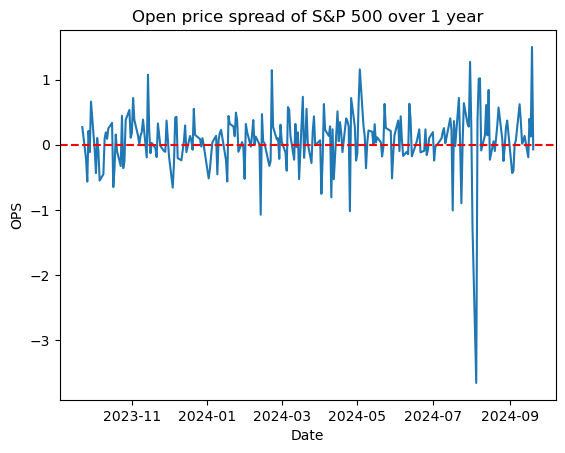

In [6]:
import matplotlib.pyplot as plt
graph_data = stock_ops_data.drop(0)
plt.plot(graph_data['Date'], graph_data['OPS'])
plt.axhline(y=0, linestyle='--', color='red')
plt.title('Open price spread of S&P 500 over 1 year')
plt.xlabel('Date')
plt.ylabel('OPS')
plt.show()

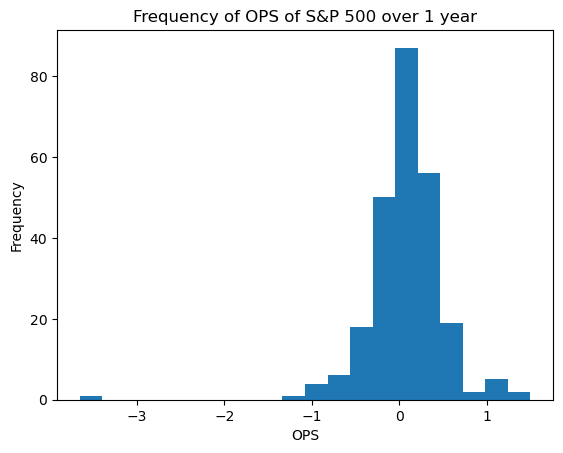

In [7]:
plt.hist(graph_data['OPS'], bins=20)
plt.title('Frequency of OPS of S&P 500 over 1 year')
plt.xlabel('OPS')
plt.ylabel('Frequency')
plt.show()

In [8]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [11]:
from statsmodels.tsa.stattools import adfuller
time_series = graph_data['OPS']
stationary_check = adfuller(time_series)
print('ADF Statistic: ', stationary_check[0])
print('p-value: ', stationary_check[1])
if(stationary_check[1] < 0.05):
    print('Data is stationary')
else:
    print('Data is not stationary')
    print('Differencing')
    time_series = time_series.diff().dropna()

ADF Statistic:  -12.571154631745681
p-value:  2.0028052553083976e-23
Data is stationary


c:\Users\olive\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


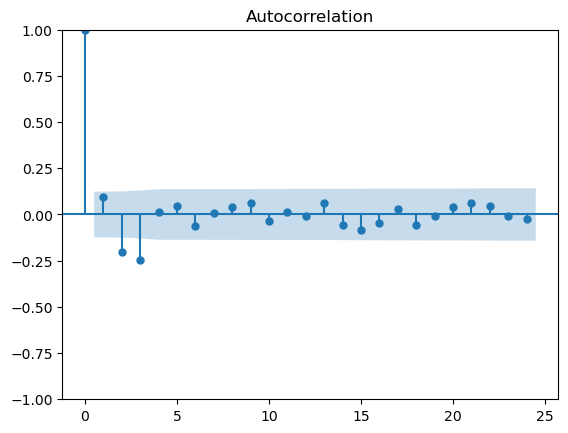

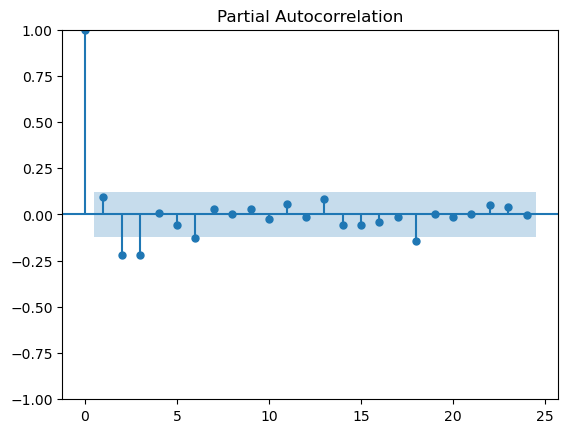

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(time_series)
plot_pacf(time_series)
plt.show()

In [14]:
model = ARIMA(time_series, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    OPS   No. Observations:                  251
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -151.547
Date:                Mon, 23 Sep 2024   AIC                            311.095
Time:                        11:07:25   BIC                            325.197
Sample:                             0   HQIC                           316.770
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0702      0.012      5.646      0.000       0.046       0.095
ar.L1          0.8390      0.100      8.397      0.000       0.643       1.035
ma.L1         -0.9415      0.070    -13.460      0.0

In [15]:
forecast = model_fit.forecast(steps=10)
print(forecast)

252   -0.100019
253   -0.072608
254   -0.049610
255   -0.030316
256   -0.014129
257   -0.000548
258    0.010845
259    0.020404
260    0.028424
261    0.035152
Name: predicted_mean, dtype: float64


In [16]:
test_data = time_series[-10:]
prediction = model_fit.forecast(steps=len(test_data))
mse = mean_squared_error(test_data, prediction)
print('Mean Squared Error: ', mse)


Mean Squared Error:  0.3119343044203375


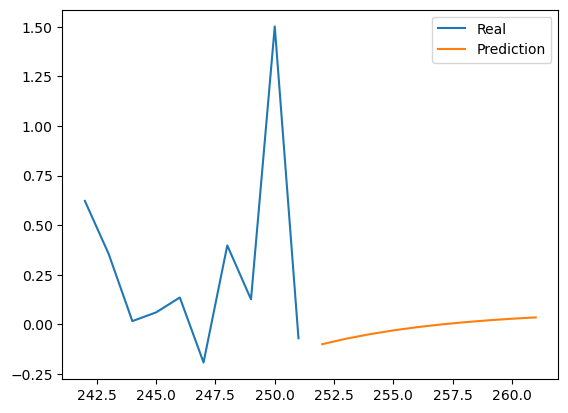

In [18]:
plt.plot(test_data, label='Real')
plt.plot(prediction, label='Prediction')
plt.legend()
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import LSTM, Dense


In [ ]:
time_series2 = graph_data['OPS']